In [1]:
""" Playing with Examples given in
    the Python Data Science Handbook
    Chapter 5, Section 3:
    Hyperparameters and Model Validation
    https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html
"""

from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target


In [2]:
""" Let's look at this first Iris dataset a little
"""
print('Size of Dataset:')
print(X.shape)
print(y.shape)

print('\nExample data:')
print(X[48:52])
print(y[48:52])

Size of Dataset:
(150, 4)
(150,)

Example data:
[[ 5.3  3.7  1.5  0.2]
 [ 5.   3.3  1.4  0.2]
 [ 7.   3.2  4.7  1.4]
 [ 6.4  3.2  4.5  1.5]]
[0 0 1 1]


In [3]:
""" Model Validation, the Ridiculously Wrong Way
    (training and testing on the same data)
    
    Also, the "k-nearest neighbors classifier"
    algorithm relates each new point to the
    closest point in the original set.
"""
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=1)
model.fit(X, y)
y_model = model.predict(X)

from sklearn.metrics import accuracy_score

accuracy_score(y, y_model)

1.0

In [4]:
""" Obviously, if you have a 100% accuracy you should probably pause and think about that a bit.
    That will usually be a totally fictional result.  Was there no noise in the data at all?
    Did you build a completely accurate scientific model of the result?
    
    So, let's break our data into training and validate sets,
    that will allow us to test our model on fresh data.
    
    For this we will use sklearn's `train_test_split`.
"""
from sklearn.cross_validation import train_test_split

# split the data with 50% in each set
X1, X2, y1, y2 = train_test_split(X, y, random_state=0, train_size=0.5)

# fit the model on one set of data
model.fit(X1, y1)

# evaluate the model on the second set of data
y2_model = model.predict(X2)
accuracy_score(y2, y2_model)

0.90666666666666662

In [9]:
""" Okay, so our first-try k-nearest neightbors fit only got us
    90% accuracy. Sure, that sounds plausible.
    
    Ignoring the book for a second, let's try some other
    k-nearest neighbors fits.
"""
def test_k_nearest(neighbors, fraction):
    model = KNeighborsClassifier(n_neighbors=neighbors)
    X1, X2, y1, y2 = train_test_split(X, y, random_state=0, train_size=fraction)
    model.fit(X1, y1)
    y2_model = model.predict(X2)
    print(accuracy_score(y2, y2_model))

test_k_nearest(1, 0.5)
test_k_nearest(1, 0.75)
test_k_nearest(2, 0.75)
test_k_nearest(10, 0.75)
test_k_nearest(1, 0.9)


0.906666666667
0.973684210526
0.973684210526
0.973684210526
1.0


In [10]:
""" Okay, so k-nearest neighbors is not a great algorithm for this.
    Though clearly more data would help.

    Now let's try some cross-validation.
"""
y2_model = model.fit(X1, y1).predict(X2)
y1_model = model.fit(X2, y2).predict(X1)
accuracy_score(y1, y1_model), accuracy_score(y2, y2_model)

(0.95999999999999996, 0.90666666666666662)

In [11]:
""" Or, in a more automated fashion
"""
from sklearn.cross_validation import cross_val_score
cross_val_score(model, X, y, cv=5)

array([ 0.96666667,  0.96666667,  0.93333333,  0.93333333,  1.        ])

In [12]:
""" The leave-one-out cross validation method is also in sklearn
"""
from sklearn.cross_validation import LeaveOneOut
scores = cross_val_score(model, X, y, cv=LeaveOneOut(len(X)))
scores.mean()

0.95999999999999996

In [7]:
""" The `pipeline` in sklearn provides a handy way
    to sequentially apply a bunch of transformations
    to the data and then apply a model,
    all in one go:
"""
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))


In [8]:
""" And now we'll create some data.
"""
import numpy as np

def make_data(N, err=1.0, rseed=1):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

X, y = make_data(40)

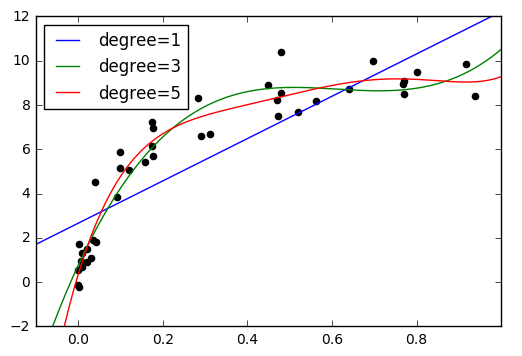

In [6]:
""" We can now visualize our data,
    along with polynomial fits of several degrees:
"""
%matplotlib inline
import matplotlib.pyplot as plt

X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.scatter(X.ravel(), y, color='black')
axis = plt.axis()
for degree in [1, 3, 5]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best');



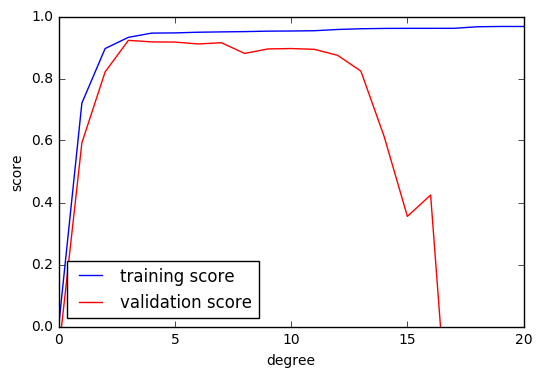

In [9]:
""" Clearly, the order of the polynomial you fit is the single
    independent variable for your fit.
    Sklearn provides some automated tools to make a
    validation curve while testing this fit variable.
"""
from sklearn.learning_curve import validation_curve
degree = np.arange(0, 21)
train_score, val_score = validation_curve(PolynomialRegression(), X, y,
                                          'polynomialfeatures__degree', degree, cv=7)

plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

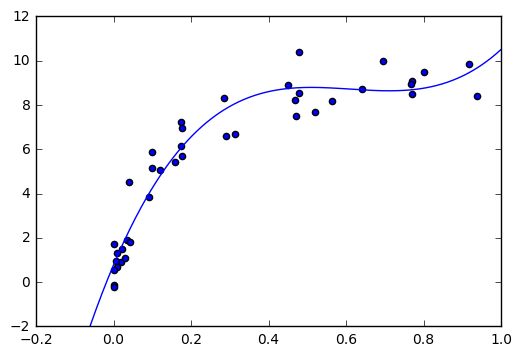

In [10]:
""" Okay, so a polynomial of order 3 seems like the best fit.
"""
plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = PolynomialRegression(3).fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);

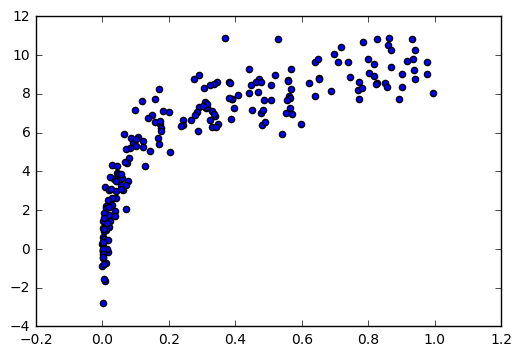

In [11]:
""" Learning Curves
    First, let's generate slightly more data.
"""
X2, y2 = make_data(200)
plt.scatter(X2.ravel(), y2);

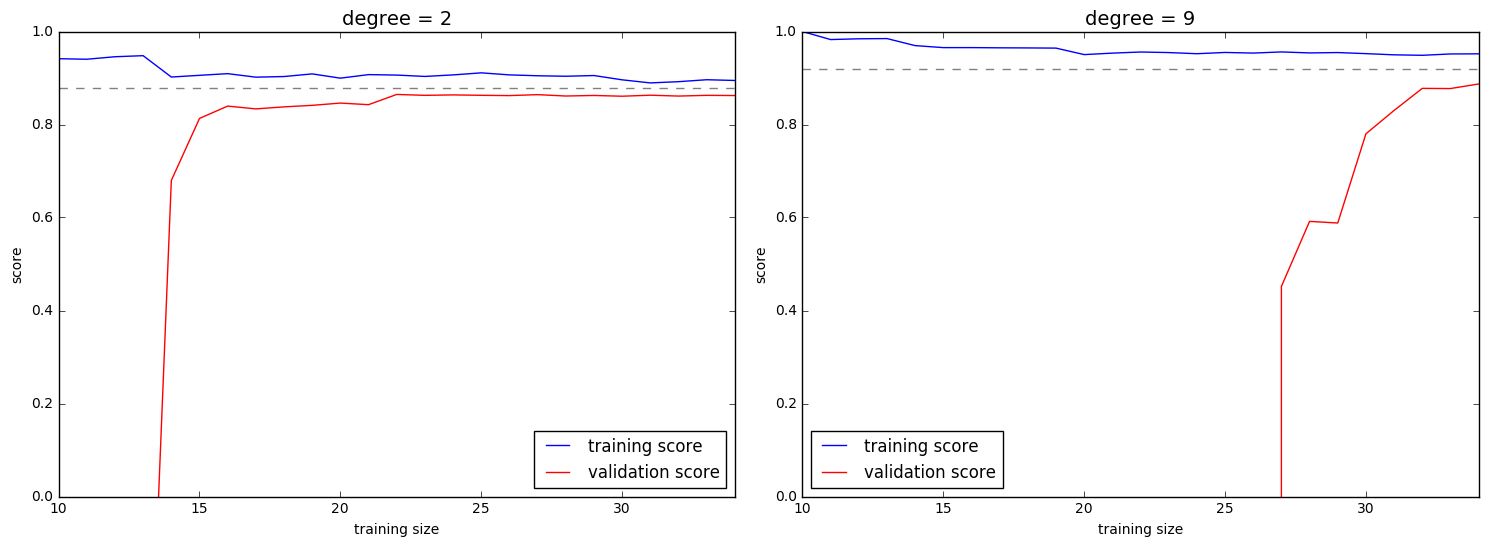

In [12]:
""" sklearn also has a tool for plotting learning curves
"""
from sklearn.learning_curve import learning_curve

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for i, degree in enumerate([2, 9]):
    N, train_lc, val_lc = learning_curve(PolynomialRegression(degree),
                                         X, y, cv=7,
                                         train_sizes=np.linspace(0.3, 1, 25))

    ax[i].plot(N, np.mean(train_lc, 1), color='blue', label='training score')
    ax[i].plot(N, np.mean(val_lc, 1), color='red', label='validation score')
    ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
                 color='gray', linestyle='dashed')

    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(N[0], N[-1])
    ax[i].set_xlabel('training size')
    ax[i].set_ylabel('score')
    ax[i].set_title('degree = {0}'.format(degree), size=14)
    ax[i].legend(loc='best')

In [14]:
""" The general behavior we would expect from a learning curve is this:

    A model of a given complexity will overfit a small dataset:
        this means the training score will be relatively high,
        while the validation score will be relatively low.
    A model of a given complexity will underfit a large dataset:
        this means that the training score will decrease,
        but the validation score will increase.
    A model will never, except by chance, give a better score
    to the validation set than the training set:
        this means the curves should keep
        getting closer together but never cross.
"""
print(1)

1


In [15]:
""" sklearn also has a grid search tool
"""
from sklearn.grid_search import GridSearchCV

param_grid = {'polynomialfeatures__degree': np.arange(21),
              'linearregression__fit_intercept': [True, False],
              'linearregression__normalize': [True, False]}

grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)

grid.fit(X, y)

grid.best_params_

{'linearregression__fit_intercept': False,
 'linearregression__normalize': True,
 'polynomialfeatures__degree': 4}

(-0.20000000000000001, 1.0000000000000002, -2.0, 12.0)

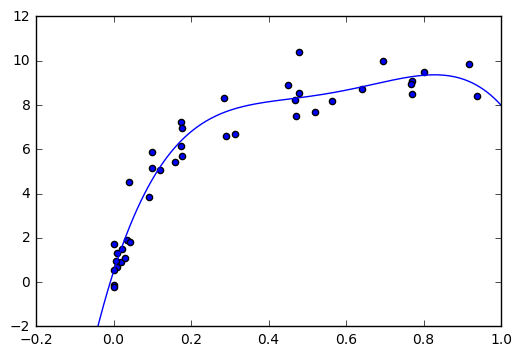

In [16]:
model = grid.best_estimator_

plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = model.fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test, hold=True)
plt.axis(lim)